<a href="https://colab.research.google.com/github/RAHULSKILLER/iNT_project/blob/main/Anomaly_Detection_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Anomaly Detection with LSTM Autoencoder on NASA C-MAPSS Dataset

In [2]:
# Step 1: Install dependencies (Colab usually has these)
!pip install pandas numpy scikit-learn tensorflow


In [3]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [4]:
# Step 3: Upload the dataset
from google.colab import files
uploaded = files.upload()


Saving train_FD001.txt to train_FD001.txt


In [5]:
# Step 4: Load the dataset (adjust file name if different)
file_name = 'train_FD001.txt'
columns = ['unit_number', 'time_in_cycles'] + \
          [f'operational_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]
df = pd.read_csv(file_name, sep='\s+', header=None, names=columns)


In [6]:
# Step 5: Normalize sensor data
sensor_cols = [col for col in df.columns if "sensor" in col]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [7]:
# Step 6: Prepare training sequences from early healthy cycles
sequence_length = 30
normal_data = []

for unit in df['unit_number'].unique():
    unit_data = df[df['unit_number'] == unit].sort_values('time_in_cycles')
    early_cycles = unit_data[unit_data['time_in_cycles'] <= 50]
    for i in range(len(early_cycles) - sequence_length):
        seq = early_cycles.iloc[i:i+sequence_length][sensor_cols].values
        normal_data.append(seq)

normal_data = np.array(normal_data)
normal_data.shape


(2000, 30, 21)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Define model parameters
input_dim = len(sensor_cols)
timesteps = sequence_length

# Build the Autoencoder model
input_layer = Input(shape=(timesteps, input_dim))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)
output = TimeDistributed(Dense(input_dim))(decoded)

# Define and compile the model
autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
history = autoencoder.fit(normal_data, normal_data,
                          epochs=20,
                          batch_size=32,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0830 - val_loss: 0.0092
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0083 - val_loss: 0.0048
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

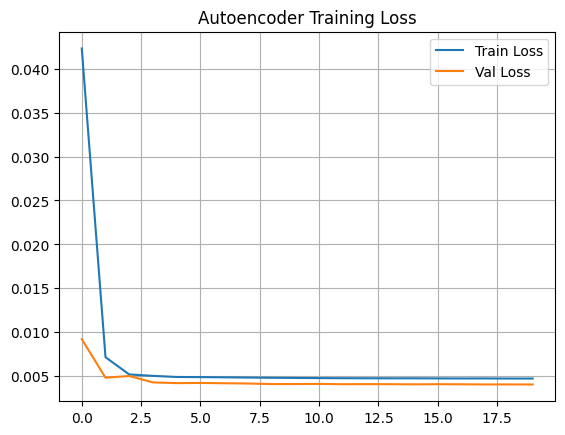

In [9]:
# Step 8: Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid()
plt.show()


In [10]:
# Upload test_FD001.txt
from google.colab import files
uploaded = files.upload()

# Make sure file name matches exactly
file_name = 'test_FD001.txt'  # Adjust if needed

# Load and normalize test data
test_df = pd.read_csv(file_name, sep='\\s+', header=None, names=columns)
test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])  # Use same scaler

# Create sequences from test data
test_sequences = []
test_indices = []

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit].sort_values('time_in_cycles')
    for i in range(len(unit_data) - sequence_length):
        seq = unit_data.iloc[i:i+sequence_length][sensor_cols].values
        test_sequences.append(seq)
        test_indices.append(unit_data.iloc[i+sequence_length-1][['unit_number', 'time_in_cycles']].values)

test_sequences = np.array(test_sequences)

# Predict with trained Autoencoder
reconstructions = autoencoder.predict(test_sequences)

# Calculate reconstruction error
mse = np.mean(np.power(test_sequences - reconstructions, 2), axis=(1, 2))

# Create DataFrame for analysis
test_error_df = pd.DataFrame(test_indices, columns=["unit_number", "time_in_cycles"])
test_error_df["reconstruction_error"] = mse

# Set threshold (95th percentile of error)
threshold = np.percentile(mse, 95)
test_error_df["anomaly"] = test_error_df["reconstruction_error"] > threshold

# Show first few anomalies
test_error_df[test_error_df["anomaly"] == True].head()

Saving test_FD001.txt to test_FD001.txt
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


,unit_number,time_in_cycles,reconstruction_error,anomaly
626,10.0,30.0,0.009930,True
627,10.0,31.0,0.010897,True
628,10.0,32.0,0.010831,True
629,10.0,33.0,0.009732,True
630,10.0,34.0,0.010639,True


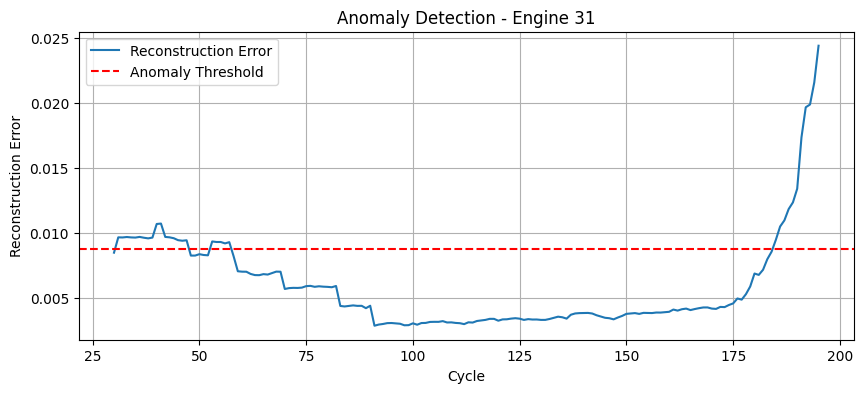

In [13]:
import matplotlib.pyplot as plt

# Plot reconstruction error for a specific engine
unit_id = 31
unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()

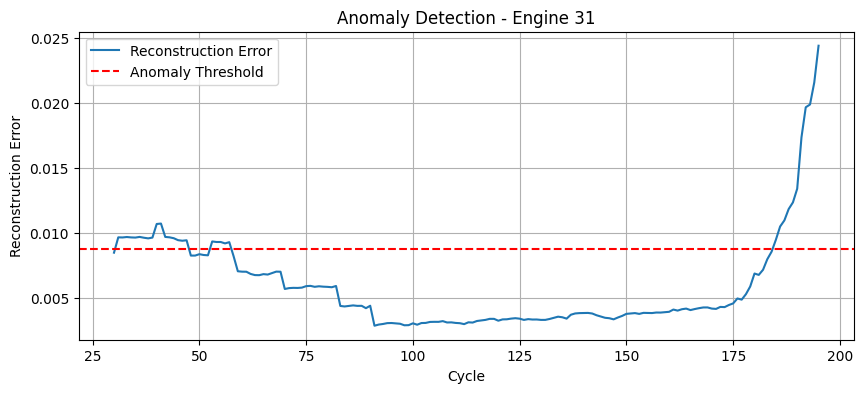

In [14]:
unit_id = 31

unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


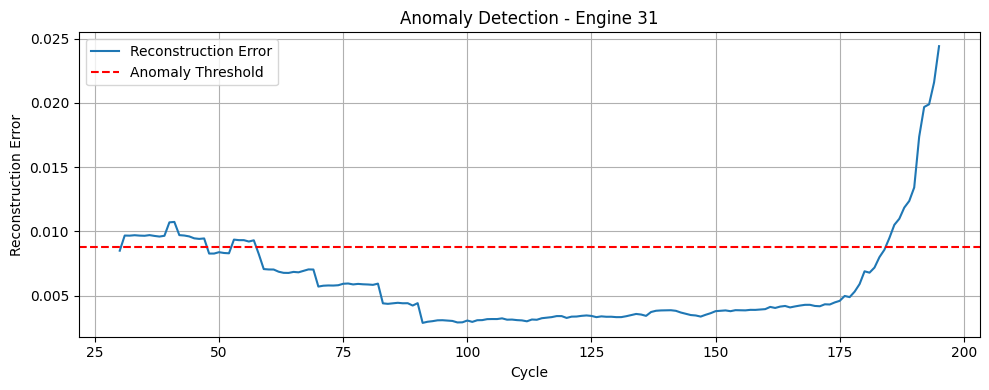

In [16]:
# Task 1.6: Compute reconstruction error on test sequences
reconstructions = autoencoder.predict(test_sequences)
reconstruction_error = np.mean(np.power(test_sequences - reconstructions, 2), axis=(1, 2))

# Task 1.7: Define a threshold (95th percentile of training reconstruction error)
threshold = np.percentile(reconstruction_error, 95)

# Task 1.8: Flag anomalies
test_error_df = pd.DataFrame(test_indices, columns=["unit_number", "time_in_cycles"])
test_error_df["reconstruction_error"] = reconstruction_error
test_error_df["anomaly"] = test_error_df["reconstruction_error"] > threshold

# Task 1.9: Visualize anomaly trend for a specific engine
unit_id = 31  # You can change this to another engine number
unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
